In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data: float, _children: tuple = (), _op: str = "", label: str = ""): 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op="*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):  # other * self
        return self * other
    
    def __truediv__(self, other):  # self / other
        out = self * other**-1
        return out
    
    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise ValueError("Only supporting int/float for now")
        out = Value(self.data**other, (self, ), _op=f"**{other}")
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
        
    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self, ), _op="exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        out = Value((np.exp(2 * x) - 1) / (np.exp(2 * x) + 1), (self, ), _op="tanh")
        
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological_sort(child)
                topo.append(v)
        build_topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self): 
        return f"Value(data={self.data})"

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

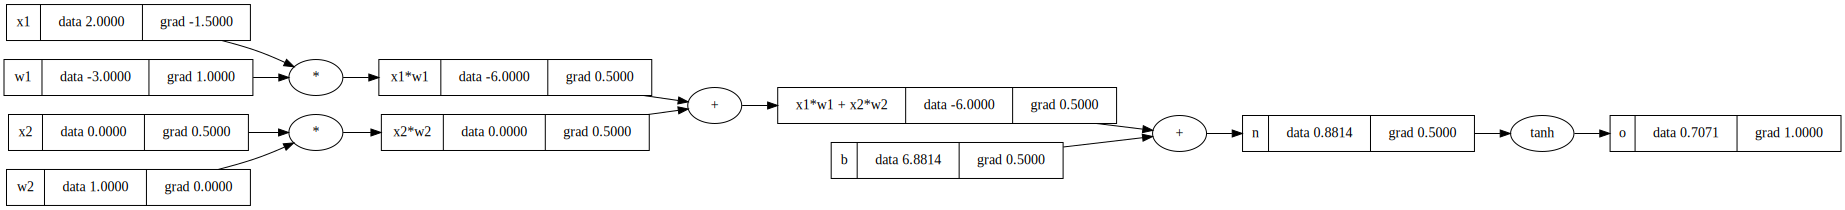

In [5]:
o.backward()
draw_dot(o)

In [6]:
Value(2.0) * 3

Value(data=6.0)

In [7]:
3 * Value(2.0)

Value(data=6.0)

In [8]:
2+ Value(3.0).exp()

Value(data=22.085536923187668)

In [11]:
a = Value(4.0)
b = Value(2.0)
c = a - b
c

Value(data=2.0)

In [12]:
c.backward()